# Imports

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_validation import StratifiedKFold
from numpy.random import normal
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os
print(os.listdir("data"))

['A_indiv_train.csv', 'A_indiv_train.csv.zip', 'credit1.csv', 'credit1.csv.zip', 'ctr_data.csv', 'ctr_data.csv.zip', 'IMDB-Movie-Data1.csv', 'vgsales1.csv', 'vgsales1.csv.zip']


[Credits](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study/notebook)  A great article about Mean encoding on Kaggle

<h2> High cardinality categorical features </h2> <br>
Features with a lot of different categories require different approaches to encoding then low cardinality features. One-hot encoding will create a huge amount of columns and harm the column sampling process in tree methods: one-hot encoded columns will overcrowd all other predictors and make high cardinality feature to be way too disproportionally important for a model. Label encoding will be hard to process for a model, because of how random it will look and how many splits will be needed.

<h3> Feature interactions usually cause high cardinality </h3><br>
In many settings, hand-picked feature interactions can be quite useful. They help a model to extract information from the data with fewer splits and improve its performance. By combining several categorical or binned continuous variables, we usually create a new set of high-cardinal feature. This creates a greater need for a proper encoding scheme.


<h2>Popular encodings for categorical variables, advantages and disadvantages for tree based models</h2>
<h3>One-hot encoding - good for linear models</h3><br>
One-hot encoding maps each category to a vector in  R(n−1)  or  R(n−k)  where  n>k>1  if we want to skip some categories. Each vector in a vector contains one '1' and all the rest of its values are '0'. That encoding is usually used in linear models and is not the best choice for tree models.

__Advantages:__

- Each category is properly separated from others. We put no assumptions about the relationships between categories with that encoding, so the model is less biased in that sense.
- Very easy to implement.

__Disadvantages:__

- For high cardinality features, one hot encoding produces a lot of columns. It slows down learning significantly and if the model randomly samples a fraction of features for each tree or split, then the chances of one-hot encoded feature to be present in a sample are artificially increased, and chances of other (not one-hot encoded) variables to be considered on a split/tree are reduced. That makes a model treat one-hot encoded features as more useful than the other features.
- On each split, trees can only separate one category from the others. Trees have to put every category in a separate bin, there is no other way to split a one hot encoded column but between 0 and 1. That leads to more splits needed to achieve same train accuracy as other, more compact encodings. That again, slows learning and prevents trees from putting similar categories together in one bin, which might reduce the quality of the model.

<h3> Label and frequency encoding </h3><br>
Label encoding is a mapping of each category to some number in  R1 . Numbers (labels) are usually chosen in a way that has no or almost no meaning in terms of relationships between categories. So, categories encoded with numbers that are close to each other (usually) are not more related than categories encoded with numbers that are far away from each other.

Frequency encoding is a way to utilize frequencies of categories as labels. It can help if frequency correlates with the target and also, it can help the model to understand that smaller categories are less trustworthy then bigger ones, especially when frequency encoding is used in parallel with other types of encoding.

__Advantages (compared to one-hot encoding):__
- Faster learning than with one-hot representations. Numbers in  R1  are way more compact representations than vectors in  Rn−1  used in one-hot encoding, that leads to fewer features for trees, which leads to faster learning.
- Less splits needed, means a more robust model. Unlike with one hot encoding, here trees can separate several categories at a time (with one-hot it is always 1).
- Easy to implement.

__Disadvantages:__
- Bias. Label encoding is biased in a way that assumes a particular ordered relationship between categories. In reality, due to randomness in assigning labels, that relationship does not exist.
- Nonlinearity towards target variable, more splits. At each binary split, tree models need to find a value of a variable that separates the target as good as possible. It is way harder to achieve when feature and target have almost zero linear dependencies. Trees have to do a lot of splits to put individual categories in separate buckets to continue to improve train loss.

<h2> Mean target encoding</h2> <br>
Plain mean target encoding can be viewed as a variation of label encoding, that is used to make labels correlate with the target. For each category, we set it's label to the mean value of a target variable on a training data. <br>
\begin{equation*}
label_c=p_c
\end{equation*}
 
Where  p<sub>c</sub>  is a mean target value for the category  c. <br>
We __do not__ use test data to estimate encodings, for the obvious reason: we should treat test data like we do not know target for it.

__Advantages (compared to label encoding):__
- Fewer splits, faster learning. Trees can utilize the linear relationships between labels and target. This is especially useful when working with high cardinality categorical features: it is hard for a model to put every small category into a separate bucket, but if a lot of small categories can be put in one bin together based on their mean target value, then trees can learn way faster.
- Less bias, since now labels have more meaning: closer labels mean closer categories in terms of the mean target variable.

__Disadvantages:__
- Harder to construct and do validation.
- Easy to overfit if regularization is not used.

<h3> Overfitting with mean target encoding </h3> <br>
When we are dealing with high cardinality features, a lot of categories have a small number of samples in them. Many of those categories will look like great predictors for a model, when in fact they are not.

Consider a binary target __Y__, and suppose that it's distribution for some category is completely random: <br>
\begin{equation*}
P(Y|category_1)=Bernoulli(0.5) 
\end{equation*}
<br>
That implies that the category has 0 predicting power (when considered by itself).

But, let's say now we have 5 examples in train data with that category (equivalent to sampling 5 times from the distribution Bernoulli(0.5)), what is the probability category will look like a good predictor? Probability to get all five 1's or all five 0's is 0.0625. So, if we have 100 categories like this one, with 5 samples and 0 predicting power, we expect at least 6 of them to have a target of all 0's or target of all 1's.

Then, if we add combinations where four values of the target are the same (still looks like a great predictor), the probability of that happening equals 0.375! More than every third category with 0 predicting power, on a small sample size of 5 samples will look like a decent predictor.

Trees will put those categories in a separate leafs and will learn to predict extreme values for those categories. Then, when we get the same categories in test data, most of them will not have the same target distribution, and model predictions will be wrong.

<h3> Using the prior probability for regularization</h3> <br>
Let's keep using a binary response variable as an example. Regression tasks will all have the same intuitions as binary classification behind them.

Simplest regularization technique is to move encodings of rare categories closer to the dataset target mean, both on train and test data. That way we hope that the model will be less likely to learn very high or very low probabilities for small categories: their encodings will now be closer to the middle and kind of blend with encodings for categories that have a smaller mean target value.

Now encoding for each category in both train and test data will be estimated as:
\begin{equation*}
label_c=\frac{(p_c∗n_c+p_{global}∗α)}{(n_c+α)}
\end{equation*}
Where  p<sub>c</sub> is a target mean for a category,  n<sub>c</sub>  is a number of samples in a category,  p<sub>global</sub>  is a global target mean and  α  is a regularisation parameter that can be viewed as a size of a category you can trust.

Drawbacks are obvious, encoding is still just pseudo continuous, every category will be encoded with a distinct real number, that still allows the model to put any category in a distinct leaf and set an extreme target probability for the leaf. It's is just a bit harder for the model to do it now, because the encodings for those categories are closer to the middle, instead of also having extreme values, so the model needs more splits to overfit.

What we need is to somehow randomize encodings inside a category, so that those small categories with extreme target values will be hard to put in a distinct bin, but bigger categories that we cab trust will still have its encodings close the mean target value for them. Randomize, but still, let the model learn that there is a correlation between category encoding and the target variable.

<h3> K-fold regularization for mean encodings</h3> <br>
The idea behind k-fold regularization is to use just a part of examples of a category to estimate the encoding for that category. Split the data into k-folds and for each example, estimate it's encoding using all folds except the one that the example belongs to. We can use the global mean regularization in combination with k-fold for more robust encoding.

Now the encoding estimation is a 3-step procedure:

1. Split train data into k folds.
Then, for each sample:

2. Exclude the fold that contains a sample.

3. Estimate encoding for the sample with the data that left using equation above

Notice that k-fold regularization is only performed for training data, test labels are still estimated from all training examples, since we do not know the labels to the test data and definitely cannot use them for estimating encodings.

I believe that the best number of folds is between 3 and 6, depending on how much randomization you want to achieve. Fewer folds for stronger randomization in terms of bigger variance of labels for each category.

<h3> Expanding mean regularization</h3> <br>
__Process:__

Fix some random permutation of rows (samples)
Moving from top to bottom, for each example, estimate the encoding using target mean of all the examples before the estimated one. An estimated example is not used.
That way we create even more randomization of encoding inside each category. Every train sample in each category now estimated from a different subsample of train data. Smaller categories got more randomization, bigger categories got less randomization and more samples encoded with numbers closer to the category mean, by the law of large numbers. That is a very useful property because overfitting arises mostly because of those smaller categories.

The main drawback is that sometimes this regularization can add noise and make a lot of categories useless. Examples of that happening will be shown later in this article.

<h2> Datasets</h2><br>
More datasets will be extended in the future, but for now I used the below six to study the effectiveness of mean encoding compared to other encoding methods and compare different regularization schemes:

[IMDB movie revenue](https://www.kaggle.com/PromptCloudHQ/imdb-data) - 872 samples. Regression task, a small dataset, mixed high and low cardinality features.<br>
[Video Game Sales](https://www.kaggle.com/gregorut/videogamesales). 16291 samples. Regression task, bigger dataset, mixed high and low cardinality features.<br>
[World Bank poverty prediction](https://www.drivendata.org/competitions/50/worldbank-poverty-prediction/). 37560 samples. Classification, big dataset, features of a lower cardinality then other datasets.<br>
[World Bank poverty prediction (interactions)](https://www.drivendata.org/competitions/50/worldbank-poverty-prediction/). 37560 samples. Classification, big dataset, high cardinality features are created by feature interactions.<br>
[Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk). 109742 samples. Classification, big dataset, a mix of high and low cardinality features. Low cardinality features are created by feature interactions.<br>
[Avazu Click-Through Rate Prediction](https://www.kaggle.com/c/avazu-ctr-prediction/data). 100000 samples. Classification, big dataset, extremely high cardinality features.<br><br>
I changed a bit in every dataset, created some new features using feature interactions so that I have more high cardinality categorical variables to work with. Also, I either deleted numerical columns (or binned them), for clearer experiment results and in some, used just a part of the data.

<h2>Encoding tests</h2> <br>
On every dataset, I trained a sklearn implementation of gradient boosted trees, made a train/test split, capture the best test score the model achieved and the number of iteration that score was achieved at.

I also provide two important statistics about the mean encodings that will help us understand how much randomness each regularization adds to the train data.

<h3>Testing procedure</h3> <br>
1. Train/test split
2. Encode all columns using the same method. When dealing with mean encoding regularizations, regularize only train data.
3. Test a gradient boosted trees model from sklearn several times, with a different number of learners.
4. Summarize the results

<h2>Encoding statistics</h2><br>
1. __Encoding variability inside categories (EV)__ Describes the variation of encodings of individual samples inside one category. Obviously, when we do not use regularization and encode all samples with one number (adjusted mean), this score is equals to 0. When we use k-fold or expanding mean methods, the score is > 0.
\begin{equation*}
EV=\frac{1}{ncols}⋅(\sum_{col}Var (E |p_c| )^{\frac12}) 
\end{equation*}


Where  p_c  is an encoding for a particular category of a particular column,  E|p<sub>c</sub>|  is an expected value of that encoding (mean of the encodings for individual samples,  Var  is a variance and  ncols  is a number of columns that were analyzed.
2. __Encoding distinguishability between categories (ED)__ How much variation are theere between the average of encoded samples in each category. So to be clear: we encode each category, then count the mean of encodings inside each category and then count standard deviation of those means. That shows how distinguishable encoded categories are, are they far away from each other or they concentrated in close areas.
\begin{equation*}
ED=\frac{1}{ncols}⋅(\sum_{col}E[Var(p_c)^{\frac12}])
\end{equation*}


<h2> Create common functions </h2>

In [ ]:
def label_encode(train_data, test_data, columns):
    'Returns a DataFrame with encoded columns'
    encoded_cols = []
    for col in columns:
        factorised = pd.factorize(train_data[col])[1]
        labels = pd.Series(range(len(factorised)), index=factorised)
        encoded_col_train = train_data[col].map(labels) 
        encoded_col_test = test_data[col].map(labels)
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = -1
        encoded_cols.append(pd.DataFrame({'label_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])
def freq_encode(train_data, test_data, columns):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    nsamples = train_data.shape[0]
    for col in columns:    
        freqs_cat = train_data.groupby(col)[col].count()/nsamples
        encoded_col_train = train_data[col].map(freqs_cat)
        encoded_col_test = test_data[col].map(freqs_cat)
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = 0
        encoded_cols.append(pd.DataFrame({'freq_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])

In [ ]:
def mean_encode(train_data, test_data, columns, target_col, reg_method=None,
                alpha=0, add_random=False, rmean=0, rstd=0.1, folds=1):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        if reg_method == 'expanding_mean':
            train_data_shuffled = train_data.sample(frac=1, random_state=1)
            cumsum = train_data_shuffled.groupby(col)[target_col].cumsum() - train_data_shuffled[target_col]
            cumcnt = train_data_shuffled.groupby(col).cumcount()
            encoded_col_train = cumsum/(cumcnt)
            encoded_col_train.fillna(target_mean_global, inplace=True)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, size=(encoded_col_train.shape[0]))
        elif (reg_method == 'k_fold') and (folds > 1):
            kfold = StratifiedKFold(train_data[target_col].values, folds, shuffle=True, random_state=1)
            parts = []
            for tr_in, val_ind in kfold:
                # divide data
                df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
                # getting means on data for estimation (all folds except estimated)
                nrows_cat = df_for_estimation.groupby(col)[target_col].count()
                target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
                target_means_cats_adj = (target_means_cats*nrows_cat + target_mean_global*alpha)/(nrows_cat+alpha)
                # Mapping means to estimated fold
                encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
                if add_random:
                    encoded_col_train_part = encoded_col_train_part + normal(loc=rmean, scale=rstd, 
                                                                             size=(encoded_col_train_part.shape[0]))
                # Saving estimated encodings for a fold
                parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis=0)
            encoded_col_train.fillna(target_mean_global, inplace=True)
        else:
            encoded_col_train = train_data[col].map(target_means_cats_adj)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+target_col+'_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], all_encoded.loc[test_data.index,:])

In [27]:
def scoring_gbc_sklearn(X_train, y_train, X_test, y_test, n_estimators=100, 
                       learning_rate=1, max_depth=3, random_state=0, max_features=None,
                       min_samples_leaf=1, verbose=False):
    scores_train = []
    scores_test = []
    iterations = []
    weight_0 = 1
    weight_1 = (len(y_train) - y_train.sum())/y_train.sum()
    sample_weights = [weight_1 if i else weight_0 for i in y_train]
    log_iters = list(set((np.logspace(math.log(1, 8), math.log(500, 8), 
                                      num=50, endpoint=True, base=8, 
                                      dtype=np.int))))
    log_iters.sort()
    for i in log_iters:
        model = GradientBoostingClassifier(n_estimators=i, learning_rate=learning_rate, 
                                          max_depth=max_depth, random_state=random_state,
                                          min_samples_leaf=min_samples_leaf, max_features=max_features)
        model.fit(X_train, y_train, sample_weight=sample_weights)
        y_train_pred_scores = model.predict_proba(X_train)
        y_test_pred_scores = model.predict_proba(X_test)
        scores_train.append(roc_auc_score(y_train, y_train_pred_scores[:,1]))
        scores_test.append(roc_auc_score(y_test, y_test_pred_scores[:,1]))
        iterations.append(i)
        if verbose:
            print(iterations[-1], scores_train[-1], scores_test[-1])
    best_score = max(scores_test)
    best_iter = iterations[scores_test.index(best_score)]
    if verbose:
        print('Best score: {}\nBest iter: {}'.format(best_score, best_iter))
    return scores_train, scores_test, iterations, model

In [28]:
def test_all_encodings(train_data, test_data, target_col, testing_params, 
                       test_one_hot=False, regression=False, skip_first_iters_graph=0, max_features_one_hot=0.01):
    encoding_settings = [[label_encode, {}, 'Label encoding', '#960000'],
                         [freq_encode, {}, 'Frequency encoding', '#FF2F02'],
                         [mean_encode, {'alpha':0, 'folds':None, 'reg_method':None, 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col},
                         'Mean encoding, alpha=0', '#A4C400'],
                         [mean_encode, {'alpha':2, 'folds':None, 'reg_method':None, 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=2', '#73B100'],
                         [mean_encode, {'alpha':5, 'folds':None, 'reg_method':None, 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5', '#2B8E00'],
                         [mean_encode, {'alpha':5, 'folds':3, 'reg_method':'k_fold', 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5, 4 folds', '#00F5F2'],
                         [mean_encode, {'alpha':5, 'folds':5, 'reg_method':'k_fold', 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5, 7 folds', '#00BAD3'],
                         [mean_encode, {'alpha':5, 'folds':None, 'reg_method':'expanding_mean', 
                                        'add_random':False, 'rmean':0, 'rstd':0.0,
                                        'target_col':target_col}, 
                         'Mean encoding, alpha=5, expanding mean', '#B22BFA']]
    review_rows = []
    if test_one_hot:
        oh_settings = [[one_hot_encode, {}, 'One hot encoding', '#E7E005']]
        encoding_settings = oh_settings + encoding_settings
    feature_cols_to_use = list(train_data.columns)
    feature_cols_to_use.remove(target_col)
    if regression:
        scoring_function = scoring_gbr_sklearn
        best_score_function = min
    else:
        scoring_function = scoring_gbc_sklearn
        best_score_function = max
        
    plt.figure(figsize=(10,7))
    for encoding_function, encoding_params, str_name, color in encoding_settings:
        if encoding_function.__name__ == 'one_hot_encode':
            testing_params['max_features'] = max_features_one_hot
        else:
            testing_params['max_features'] = None
        X_train, X_test = encoding_function(train_data, test_data, feature_cols_to_use,
                                            **encoding_params)
        scores = scoring_function(X_train, train_data[target_col], X_test, 
                                    test_data[target_col], 
                                    min_samples_leaf=1, max_depth=3, **testing_params)
        skip_it = int(skip_first_iters_graph)
        train_scores, test_scores, iters, model_ = scores
        plt.plot(iters[skip_it:], 
                 test_scores[skip_it:], 
                 label='Test, ' + str_name, linewidth=1.5, color=color)
        best_score_test = best_score_function(test_scores)
        best_iter_test = iters[test_scores.index(best_score_test)]
        best_score_train = best_score_function(train_scores[:best_iter_test])
        print('Best score for {}: is {}, on iteration {}'.format(str_name, 
                                                                 best_score_test, 
                                                                 best_iter_test,
                                                                 best_score_train))
        enc_stats = encoding_stats(train_data, test_data, X_train, X_test, 
                                   target_col, encoding_function, feature_cols_to_use)
        review_rows.append([str_name, best_score_train, best_score_test, best_iter_test] + list(enc_stats))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if regression:
        columns=['Encoding', 'Train RMSE score on best iteration', 
             'Best RMSE score (test)', 'Best iteration (test)',
             'EV (train)', 'ED (train)', 'EV (test)', 'ED (test)']
    else:
        columns=['Encoding', 'Train AUC score on best iteration', 
             'Best AUC score (test)', 'Best iteration (test)',
             'EV (train)', 'ED (train)', 'EV (test)', 'ED (test)']
    return pd.DataFrame(review_rows, columns=columns)

In [29]:
def one_hot_encode(train_data, test_data, columns):
    conc = pd.concat([train_data, test_data], axis=0)
    encoded = pd.get_dummies(conc.loc[:, columns], drop_first=True, sparse=True) 
    return (encoded.iloc[:train_data.shape[0],:], encoded.iloc[train_data.shape[0]:,:])

In [30]:
def encoding_stats(train_data, test_data, X_train, X_test, target_col, encoding_function, feature_cols_to_use):
    if encoding_function.__name__ == 'one_hot_encode':
        return np.nan, np.nan, np.nan, np.nan
    if encoding_function.__name__ == 'mean_encode':
        enc_suffix = 'mean_'+target_col+'_'
    if encoding_function.__name__ == 'freq_encode':    
        enc_suffix = 'freq_'
    if encoding_function.__name__ == 'label_encode':
        enc_suffix = 'label_'
    cols_to_encoded_mapping = {}
    for col in feature_cols_to_use:
        for col_enc in X_train.columns:
            if col == col_enc[len(enc_suffix):]:
                cols_to_encoded_mapping[col] = col_enc
    train_conc = pd.concat([train_data, X_train], axis=1)
    test_conc = pd.concat([test_data, X_test], axis=1)
    mean_stds_train = []
    std_means_train = []
    mean_stds_test = []
    std_means_test = []
    for key in cols_to_encoded_mapping.keys():
        #how much randomisation added
        mean_stds_train.append(train_conc.groupby(key)[cols_to_encoded_mapping[key]].std().mean())
        mean_stds_test.append(test_conc.groupby(key)[cols_to_encoded_mapping[key]].std().mean())
        # how distinguishable are categories with that encoding
        std_means_train.append(train_conc.groupby(key)[cols_to_encoded_mapping[key]].mean().std())
        std_means_test.append(test_conc.groupby(key)[cols_to_encoded_mapping[key]].mean().std())
    
    encoding_stats = (np.mean(mean_stds_train), np.mean(std_means_train),
                      np.mean(mean_stds_test), np.mean(std_means_test))
    return encoding_stats

In [ ]:
def describe_dataset(data, target_col):
    ncats = []
    ncats10 = []
    ncats100 = []
    nsamples_median = []
    
    X_col_names = list(data.columns)
    X_col_names.remove(target_col)
    
    print('Number of samples: ', data.shape[0])
    
    for col in X_col_names:
        counts = data.groupby([col])[col].count()
        ncats.append(len(counts))
        ncats10.append(len(counts[counts<10]))
        ncats100.append(len(counts[counts<100]))
        nsamples_median.append(counts.median())
    data_review_df = pd.DataFrame({'Column':X_col_names, 'Number of categories':ncats, 
                                   'Categories with < 10 samples':ncats10,
                                   'Categories with < 100 samples':ncats100,
                                   'Median samples in category':nsamples_median})
    data_review_df = data_review_df.loc[:, ['Column', 'Number of categories',
                                             'Median samples in category',
                                             'Categories with < 10 samples',
                                             'Categories with < 100 samples']]
    return data_review_df.sort_values(by=['Number of categories'], ascending=False)

<h1> IMDB movie revenue</h1>
<h2>Dataset summary</h2><br>
Using genre, release year and rating, predict the movie sales.

4 columns, one of which is an interaction. Data is just 872 rows. All columns except for the 'Year' can be considered a high cardinality features.


In [8]:
def make_movie():
    movie = pd.read_csv('data/IMDB-Movie-Data1.csv').loc[:, ['Genre', 'Year', 'Rating', 
                                                       'Revenue (Millions)']]
    movie = movie.loc[movie['Revenue (Millions)'].notnull(), :]
    movie['Year + Rating'] = movie['Year'] + movie['Rating']
    return movie

In [15]:
movie = make_movie()
target_col = 'Revenue (Millions)'
describe_dataset(movie, target_col)

Number of samples:  872


,Column,Number of categories,Median samples in category,Categories with < 10 samples,Categories with < 100 samples
0,Genre,195,2.0,173,195
3,Year + Rating,129,6.0,99,129
2,Rating,50,14.0,21,50
1,Year,11,62.0,0,9


<h2>Testing encodings</h2>

Best score for One hot encoding: is 7580.875794455195, on iteration 245
Best score for Label encoding: is 8257.421388620522, on iteration 63
Best score for Frequency encoding: is 9457.710408935138, on iteration 16
Best score for Mean encoding, alpha=0: is 8208.086676959303, on iteration 6
Best score for Mean encoding, alpha=2: is 8114.568710922977, on iteration 5
Best score for Mean encoding, alpha=5: is 8310.804958449018, on iteration 6
Best score for Mean encoding, alpha=5, 4 folds: is 7885.377486074182, on iteration 9
Best score for Mean encoding, alpha=5, 7 folds: is 8023.1346393032245, on iteration 7
Best score for Mean encoding, alpha=5, expanding mean: is 9407.381868913339, on iteration 5


,Encoding,Train RMSE score on best iteration,Best RMSE score (test),Best iteration (test),EV (train),ED (train),EV (test),ED (test)
0,One hot encoding,2726.202201,7580.875794,245,NaN,NaN,NaN,NaN
1,Label encoding,1107.152860,8257.421389,63,0.000000,25.763158,0.0,26.835952
2,Frequency encoding,7279.697986,9457.710409,16,0.000000,0.020878,0.0,0.021270
3,"Mean encoding, alpha=0",4794.418005,8208.086677,6,0.000000,43.397180,0.0,41.256909
4,"Mean encoding, alpha=2",5042.861750,8114.568711,5,0.000000,27.261424,0.0,28.170407
5,"Mean encoding, alpha=5",4722.426336,8310.804958,6,0.000000,20.521658,0.0,21.734986
6,"Mean encoding, alpha=5, 4 folds",5771.701967,7885.377486,9,9.803503,16.186930,0.0,21.734986
7,"Mean encoding, alpha=5, 7 folds",5944.679873,8023.134639,7,8.504472,17.076585,0.0,21.734986
8,"Mean encoding, alpha=5, expanding mean",6889.696425,9407.381869,5,34.495155,35.889504,0.0,21.734986


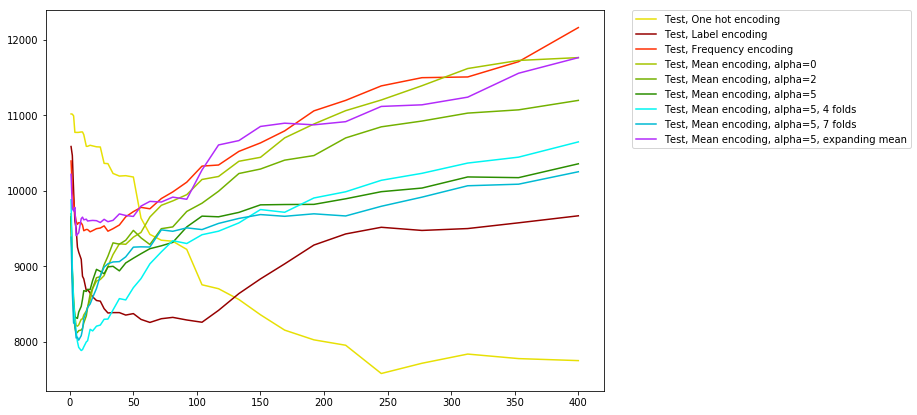

In [26]:
train_data, test_data = train_test_split(movie, test_size=0.3, random_state=4)
testing_params = {'learning_rate':0.2}

test_all_encodings(train_data, test_data, target_col, testing_params, test_one_hot=True, regression=True)

__Takeaways__
1. One-hot encoding shows way better train score than other methods.
2. Mean encodings converge to the best score way faster then one-hot and label encodings.
3. Mean encoding, alpha=5, 4 folds is the best regularization for that dataset
4. Expanding mean regularization added too much noise and the model was not able to get enough valuable information from data.

<h1>Video Game Sales </h1>
<h2>Dataset summary </h2><br>
Predict video game sales using information about release year, publisher, genre and platform.

7 columns, 3 of which are interactions. Data has 16291 rows. 1 very high cardinality column, 3 columns are high cardinality features and 3 are lower cardinality categoricals.

In [33]:
def make_vgsales():
    vgsales = pd.read_csv('data/vgsales1.csv')
    vgsales = vgsales.loc[(vgsales['Year'].notnull()) & (vgsales['Publisher'].notnull()), 
                         ['Platform', 'Genre', 'Publisher', 'Year', 'Global_Sales']]
    vgsales['Year'] = vgsales.loc[:,['Year']].astype('str')
    vgsales['Platform x Genre'] = vgsales['Platform'] + '_' + vgsales['Genre']
    vgsales['Platform x Year'] = vgsales['Platform'] + '_' + vgsales['Year']
    vgsales['Genre x Year'] = vgsales['Genre'] + '_' + vgsales['Year']
    return vgsales

In [34]:
vgsales = make_vgsales()
target_col = 'Global_Sales'
describe_dataset(vgsales, target_col)

Number of samples:  16291


,Column,Number of categories,Median samples in category,Categories with < 10 samples,Categories with < 100 samples
2,Publisher,576,3.0,424,547
6,Genre x Year,389,23.0,126,344
4,Platform x Genre,293,24.0,86,240
5,Platform x Year,241,32.0,81,177
3,Year,39,289.0,3,16
0,Platform,31,239.0,6,11
1,Genre,12,1249.5,0,0


<h2> Testing encodings</h2>

Best score for One hot encoding: is 3.0932374618713867, on iteration 400
Best score for Label encoding: is 2.977799401287068, on iteration 217
Best score for Frequency encoding: is 2.9914396615348764, on iteration 353
Best score for Mean encoding, alpha=0: is 3.062542270962852, on iteration 13
Best score for Mean encoding, alpha=2: is 3.0123991154138943, on iteration 21
Best score for Mean encoding, alpha=5: is 3.0789631340267283, on iteration 169
Best score for Mean encoding, alpha=5, 4 folds: is 2.717084548493967, on iteration 277
Best score for Mean encoding, alpha=5, 7 folds: is 2.9257918663990097, on iteration 92
Best score for Mean encoding, alpha=5, expanding mean: is 3.0982996272718935, on iteration 14


,Encoding,Train RMSE score on best iteration,Best RMSE score (test),Best iteration (test),EV (train),ED (train),EV (test),ED (test)
0,One hot encoding,1.421010,3.093237,400,NaN,NaN,NaN,NaN
1,Label encoding,1.238382,2.977799,217,0.000000,61.507635,0.0,60.073445
2,Frequency encoding,1.317066,2.991440,353,0.000000,0.019143,0.0,0.019366
3,"Mean encoding, alpha=0",1.373045,3.062542,13,0.000000,0.735573,0.0,0.668768
4,"Mean encoding, alpha=2",1.215786,3.012399,21,0.000000,0.555985,0.0,0.532439
5,"Mean encoding, alpha=5",0.959739,3.078963,169,0.000000,0.450528,0.0,0.440745
6,"Mean encoding, alpha=5, 4 folds",0.769141,2.717085,277,0.080790,0.394264,0.0,0.440745
7,"Mean encoding, alpha=5, 7 folds",0.661111,2.925792,92,0.070780,0.393305,0.0,0.440745
8,"Mean encoding, alpha=5, expanding mean",1.319145,3.098300,14,0.270566,0.614461,0.0,0.440745


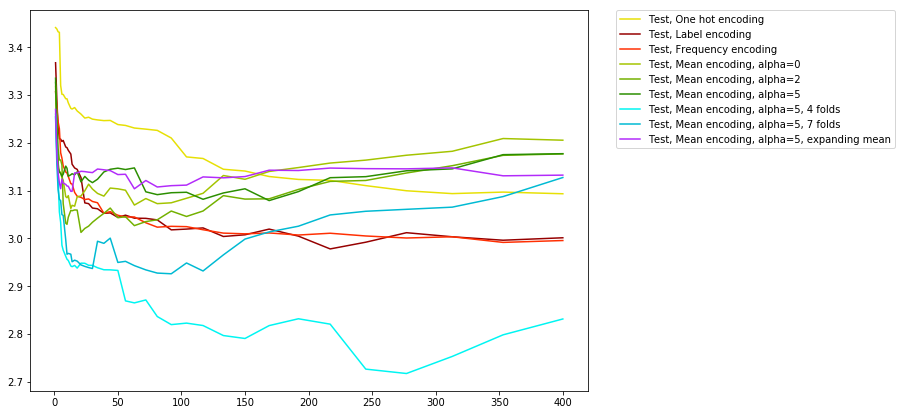

In [35]:
train_data, test_data = train_test_split(vgsales, test_size=0.3, random_state=4)
testing_params = {'learning_rate':0.35}

test_all_encodings(train_data, test_data, target_col, testing_params, test_one_hot=True, regression=True)

__Takeaways__
1. 'Mean encoding, alpha=5, 4 folds' showed the best result by far, even compared to 'Mean encoding, alpha=5, 7 folds'
2. Best regularization for mean encoding ('Mean encoding, alpha=5, 4 folds') did not actually converge faster then label encoding and just slightly faster then frequency encoding.
3. Mean encodings with no regularization and mean encoding with expanding mean regularization showed very bad results, even compared to label and frequency encodings.
4. One-hot and mean encoding with expanding mean regularization showed the worst results by far.

<h1>World Bank poverty prediction</h1>
<h2>Dataset summary</h2><br>
8 columns, no interactions. Data has 37560 rows. All columns are low or average cardinality.

In [37]:
def make_poverty():
    poverty = pd.read_csv('data/A_indiv_train.csv')
    poverty_cols_to_use = ['HeUgMnzF', 'gtnNTNam', 'XONDGWjH', 'hOamrctW', 'XacGrSou', 
                           'ukWqmeSS', 'SGeOiUlZ', 'RXcLsVAQ', 'poor']
    poverty['poor'] = poverty['poor'].astype(int)
    poverty = poverty.loc[:, poverty_cols_to_use]
    return poverty

In [38]:
poverty = make_poverty()
target_col = 'poor'
describe_dataset(poverty, target_col)

Number of samples:  37560


,Column,Number of categories,Median samples in category,Categories with < 10 samples,Categories with < 100 samples
5,ukWqmeSS,103,157.0,11,38
0,HeUgMnzF,25,283.0,7,11
4,XacGrSou,25,585.0,2,11
1,gtnNTNam,16,259.5,1,6
2,XONDGWjH,15,58.0,1,9
3,hOamrctW,15,73.0,1,8
6,SGeOiUlZ,11,188.0,0,3
7,RXcLsVAQ,8,339.5,0,3


<h2> Test encodings </h2>

Best score for One hot encoding: is 0.6700419966510206, on iteration 440
Best score for Label encoding: is 0.670838713878829, on iteration 205
Best score for Frequency encoding: is 0.6782131321993718, on iteration 65
Best score for Mean encoding, alpha=0: is 0.6754523949190823, on iteration 74
Best score for Mean encoding, alpha=2: is 0.6734428148136555, on iteration 57
Best score for Mean encoding, alpha=5: is 0.67545296284218, on iteration 57
Best score for Mean encoding, alpha=5, 4 folds: is 0.6603174652254378, on iteration 44
Best score for Mean encoding, alpha=5, 7 folds: is 0.6622444440714382, on iteration 39
Best score for Mean encoding, alpha=5, expanding mean: is 0.6520799300015852, on iteration 6


,Encoding,Train AUC score on best iteration,Best AUC score (test),Best iteration (test),EV (train),ED (train),EV (test),ED (test)
0,One hot encoding,0.695662,0.670042,440,NaN,NaN,NaN,NaN
1,Label encoding,0.729403,0.670839,205,0.000000,7.864219,0.0,7.797550
2,Frequency encoding,0.729446,0.678213,65,0.000000,0.165622,0.0,0.167274
3,"Mean encoding, alpha=0",0.729499,0.675452,74,0.000000,0.187944,0.0,0.183421
4,"Mean encoding, alpha=2",0.729510,0.673443,57,0.000000,0.156980,0.0,0.158236
5,"Mean encoding, alpha=5",0.729084,0.675453,57,0.000000,0.141379,0.0,0.142800
6,"Mean encoding, alpha=5, 4 folds",0.746828,0.660317,44,0.023120,0.132161,0.0,0.142800
7,"Mean encoding, alpha=5, 7 folds",0.752770,0.662244,39,0.018294,0.135650,0.0,0.142800
8,"Mean encoding, alpha=5, expanding mean",0.655242,0.652080,6,0.091073,0.171358,0.0,0.142800


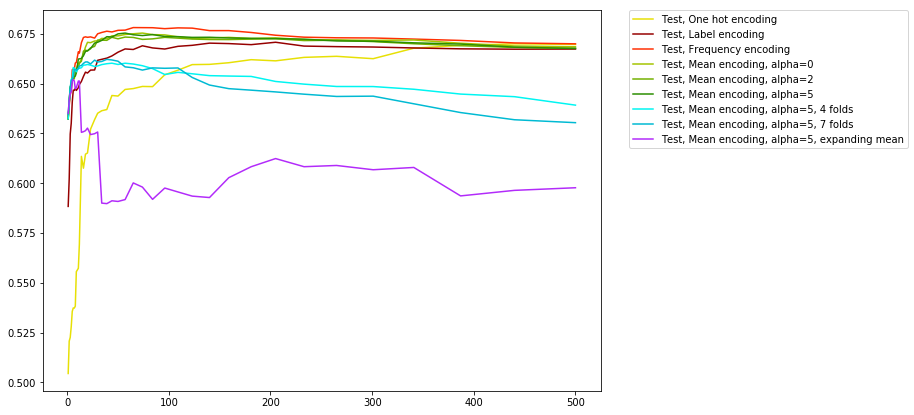

In [39]:
train_data, test_data = train_test_split(poverty, test_size=0.3, random_state=4)
testing_params = {'learning_rate':0.4}

test_all_encodings(train_data, test_data, target_col, testing_params, test_one_hot=True, regression=False)

__Takeaways__
1. Frequency encoding showed the best result on the dataset, followed by unregularized mean encoding with alpha=5.
2. More encoding randomization clearly does not help the model on this dataset. We can clearly see a negative correlation between the randomization of encodings and AUC score.
3. Frequency encoding is actually the less randomized one because some categories have the same frequencies.
4. Expanding mean regularization added way too much noise, the score is way behind scores with other encodings, overfitting is fast and severe.

<h1>World Bank poverty prediction with feature interactions</h1>
<h2>Dataset summary</h2><br>
18 columns, 10 interactions. Data has 37560 rows. All columns are different cardinality.

In [42]:
def make_poverty_interaction():
    poverty = pd.read_csv('data/A_indiv_train.csv')
    poverty_cols_to_use = ['HeUgMnzF', 'gtnNTNam', 'XONDGWjH', 'hOamrctW', 'XacGrSou', 
                            'ukWqmeSS', 'SGeOiUlZ', 'RXcLsVAQ', 'poor']
    poverty = poverty.loc[:, poverty_cols_to_use]
    poverty.loc[:, poverty_cols_to_use[:-1]] = poverty.loc[:, poverty_cols_to_use[:-1]].astype(str)
    poverty['poor'] = poverty['poor'].astype(int)
    poverty['interaction_1'] = poverty['HeUgMnzF'] + poverty['XONDGWjH']
    poverty['interaction_2'] = poverty['gtnNTNam'] + poverty['hOamrctW']
    poverty['interaction_3'] = poverty['XONDGWjH'] + poverty['XacGrSou']
    poverty['interaction_4'] = poverty['hOamrctW'] + poverty['ukWqmeSS']
    poverty['interaction_5'] = poverty['XacGrSou'] + poverty['SGeOiUlZ']
    poverty['interaction_6'] = poverty['ukWqmeSS'] + poverty['RXcLsVAQ']
    poverty['interaction_7'] = poverty['SGeOiUlZ'] + poverty['RXcLsVAQ']
    poverty['interaction_8'] = poverty['HeUgMnzF'] + poverty['gtnNTNam']
    poverty['interaction_9'] = poverty['ukWqmeSS'] + poverty['hOamrctW']
    poverty['interaction_10'] = poverty['XONDGWjH'] + poverty['RXcLsVAQ']
    return poverty

In [43]:
poverty_interactions = make_poverty_interaction()
target_col = 'poor'
describe_dataset(poverty_interactions, target_col)

Number of samples:  37560


,Column,Number of categories,Median samples in category,Categories with < 10 samples,Categories with < 100 samples
13,interaction_6,379,7.0,211,317
16,interaction_9,346,9.0,175,267
11,interaction_4,346,9.0,175,267
10,interaction_3,216,7.0,118,176
8,interaction_1,171,4.0,122,152
5,ukWqmeSS,103,157.0,11,38
15,interaction_8,84,3.0,53,61
9,interaction_2,62,9.0,31,46
17,interaction_10,57,8.0,29,47
14,interaction_7,40,12.5,18,28


<h2>Testing encodings </h2>

Best score for One hot encoding: is 0.6656937407807151, on iteration 205
Best score for Label encoding: is 0.6714473223561791, on iteration 84
Best score for Frequency encoding: is 0.6788714339477673, on iteration 84
Best score for Mean encoding, alpha=0: is 0.6656679318310548, on iteration 50
Best score for Mean encoding, alpha=2: is 0.6653488852553029, on iteration 57
Best score for Mean encoding, alpha=5: is 0.6672097641629924, on iteration 27
Best score for Mean encoding, alpha=5, 4 folds: is 0.6700795111267492, on iteration 65
Best score for Mean encoding, alpha=5, 7 folds: is 0.6666996903430862, on iteration 34
Best score for Mean encoding, alpha=5, expanding mean: is 0.65433829197507, on iteration 7


,Encoding,Train AUC score on best iteration,Best AUC score (test),Best iteration (test),EV (train),ED (train),EV (test),ED (test)
0,One hot encoding,0.720969,0.665694,205,NaN,NaN,NaN,NaN
1,Label encoding,0.744698,0.671447,84,0.000000,29.267233,0.0,28.626253
2,Frequency encoding,0.741318,0.678871,84,0.000000,0.098634,0.0,0.101517
3,"Mean encoding, alpha=0",0.748062,0.665668,50,0.000000,0.255450,0.0,0.222361
4,"Mean encoding, alpha=2",0.747110,0.665349,57,0.000000,0.169878,0.0,0.169174
5,"Mean encoding, alpha=5",0.713008,0.667210,27,0.000000,0.141580,0.0,0.145073
6,"Mean encoding, alpha=5, 4 folds",0.763323,0.670080,65,0.028403,0.126666,0.0,0.145073
7,"Mean encoding, alpha=5, 7 folds",0.745542,0.666700,34,0.024529,0.131067,0.0,0.145073
8,"Mean encoding, alpha=5, expanding mean",0.657877,0.654338,7,0.129414,0.187234,0.0,0.145073


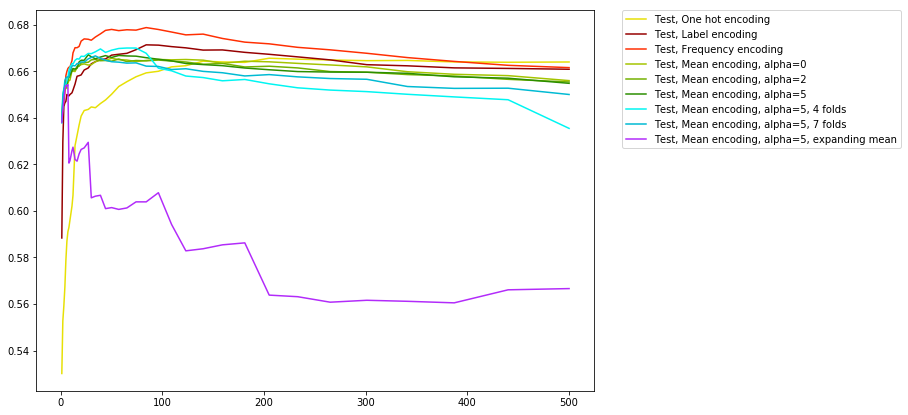

In [44]:
train_data, test_data = train_test_split(poverty_interactions, test_size=0.3, random_state=4)
testing_params = {'learning_rate':0.4}

test_all_encodings(train_data, test_data, target_col, testing_params, test_one_hot=True, regression=False)

<h2>Takeaways</h2>
1. All that applies to the dataset above (without feature interactions) is valid here.
2. Frequency encoding worked by far the best, supposedly because it helps a model understand which categories are very small and have no predictive power. Most likely, small categories are bad predictors in that dataset, so the model learned not to use them and got a better generalization (this needs further investigation).
3. Mean encoding with 4-fold regularization showed a second best result, but it is far from frequency encoding score.
4. Expanding mean encoding overfits fast and severe, again.
5. What changed is that now mean encodings with no regularization overfit more, and k-fold cvs work better.

<h1> Home Credit Default Risk</h1>
<h2>Dataset summary</h2><br>
15 columns, 10 of which are interactions of other columns (some might not be included here). Data has 109742 rows. Columns are high or average cardinality.

In [45]:
def make_credit():
    credit = pd.read_csv('data/credit1.csv')
    cols = list(credit.columns)
    cols.remove('Unnamed: 0')
    return credit.loc[:, cols]

In [46]:
credit = make_credit()
target_col = 'TARGET'
describe_dataset(credit, target_col)

Number of samples:  109742


,Column,Number of categories,Median samples in category,Categories with < 10 samples,Categories with < 100 samples
1,interaction_2,9054,2.0,7557,8891
4,interaction_5,7749,3.0,5495,7480
9,interaction_10,6691,4.0,4488,6511
0,interaction_1,6007,2.0,4904,5816
5,interaction_6,3618,25.0,715,3590
6,interaction_7,3255,23.0,685,3088
8,interaction_9,2455,6.0,1429,2232
7,interaction_8,2369,19.0,860,1973
3,interaction_4,1265,24.0,405,1011
10,EXT_SOURCE_1,933,139.0,48,288


<h2>Testing encodings</h2>

Best score for Label encoding: is 0.6268098668281611, on iteration 159
Best score for Frequency encoding: is 0.7034891024522549, on iteration 341
Best score for Mean encoding, alpha=0: is 0.5951263938751448, on iteration 44
Best score for Mean encoding, alpha=2: is 0.6317614883402618, on iteration 39
Best score for Mean encoding, alpha=5: is 0.6521379903686347, on iteration 30
Best score for Mean encoding, alpha=5, 4 folds: is 0.7139872729646485, on iteration 96
Best score for Mean encoding, alpha=5, 7 folds: is 0.7139231673501572, on iteration 84
Best score for Mean encoding, alpha=5, expanding mean: is 0.7138863118752719, on iteration 140


,Encoding,Train AUC score on best iteration,Best AUC score (test),Best iteration (test),EV (train),ED (train),EV (test),ED (test)
0,Label encoding,0.758866,0.626810,159,0.000000,804.816600,0.0,794.880080
1,Frequency encoding,0.783008,0.703489,341,0.000000,0.002775,0.0,0.002900
2,"Mean encoding, alpha=0",0.972738,0.595126,44,0.000000,0.139187,0.0,0.106200
3,"Mean encoding, alpha=2",0.967612,0.631761,39,0.000000,0.076387,0.0,0.068797
4,"Mean encoding, alpha=5",0.948891,0.652138,30,0.000000,0.055188,0.0,0.053082
5,"Mean encoding, alpha=5, 4 folds",0.785158,0.713987,96,0.018951,0.042676,0.0,0.053082
6,"Mean encoding, alpha=5, 7 folds",0.786281,0.713923,84,0.016441,0.044851,0.0,0.053082
7,"Mean encoding, alpha=5, expanding mean",0.768300,0.713886,140,0.062402,0.088322,0.0,0.053082


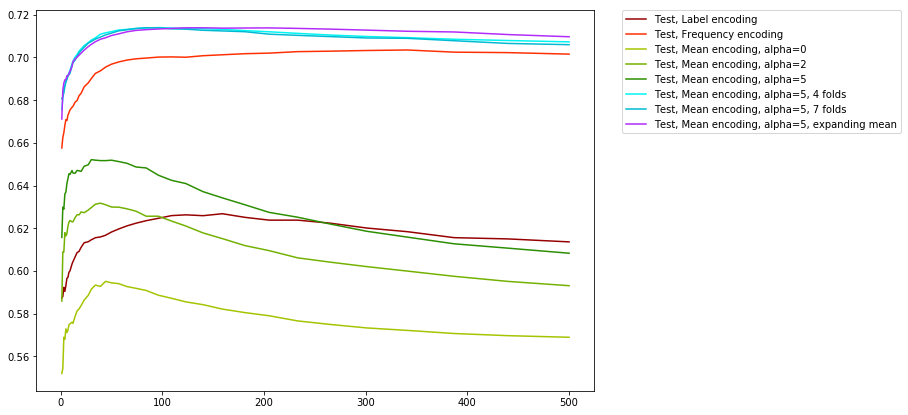

In [48]:
train_data, test_data = train_test_split(credit, test_size=0.3, random_state=4)
testing_params = {'learning_rate':0.07}

test_all_encodings(train_data, test_data, target_col, testing_params, test_one_hot=False, regression=False)

__Takeaways__
1. Expanding mean regularization finally performs really well, when the sample is big enough.
2. Frequency encoding takes twice as many trees to got to a good result copmared to regularised mean encodings.
3. Mean encodings with no regularization performed very badly, especially the one with  α=0 , overfitting is huge there with 0.972738 as a train score and just 0.595126 on the same iterarion.

<h1> Avazu Click-Through Rate Prediction</h1>
<h2>Dataset summary</h2>
All columns are with very high cardinality. 100000 rows.

In [50]:
def make_ctr():
    ctr = pd.read_csv('data/ctr_data.csv', nrows=100000)
    ctr = ctr.astype('str')
    ctr['click'] = ctr['click'].astype('int')
    ctr['interaction_1'] = (ctr['site_category'] + ctr['C15'] + ctr['C16'] + ctr['C20'] + ctr['C17'])
    ctr['interaction_2'] = (ctr['site_category'] + ctr['C18'] + ctr['C19'] + ctr['device_model'])
    ctr_cols_to_use = ['site_id', 'app_id', 'device_id',
                      'device_model', 'C14', 'interaction_1', 'interaction_2', 'click']
    ctr = ctr.loc[:, ctr_cols_to_use]
    return ctr

In [52]:
ctr = make_ctr()
target_col = 'click'
describe_dataset(ctr, target_col)

Number of samples:  100000


,Column,Number of categories,Median samples in category,Categories with < 10 samples,Categories with < 100 samples
6,interaction_2,9095,2.0,7750,8961
2,device_id,7202,1.0,7088,7200
3,device_model,2473,4.0,1644,2327
5,interaction_1,1354,4.0,926,1257
0,site_id,893,3.0,649,830
1,app_id,704,3.0,501,672
4,C14,420,13.0,188,338


<h2>Testing encodings</h2>

Best score for Label encoding: is 0.7165963983083204, on iteration 440
Best score for Frequency encoding: is 0.7363065039917909, on iteration 440
Best score for Mean encoding, alpha=0: is 0.7095347259781115, on iteration 109
Best score for Mean encoding, alpha=2: is 0.7117840617912748, on iteration 50
Best score for Mean encoding, alpha=5: is 0.7131591553020069, on iteration 39
Best score for Mean encoding, alpha=5, 4 folds: is 0.740688853531347, on iteration 44
Best score for Mean encoding, alpha=5, 7 folds: is 0.7401630620854416, on iteration 50
Best score for Mean encoding, alpha=5, expanding mean: is 0.7377586882658347, on iteration 65


,Encoding,Train AUC score on best iteration,Best AUC score (test),Best iteration (test),EV (train),ED (train),EV (test),ED (test)
0,Label encoding,0.780592,0.716596,440,0.000000,765.422084,0.0,752.687382
1,Frequency encoding,0.771112,0.736307,440,0.000000,0.011154,0.0,0.013140
2,"Mean encoding, alpha=0",0.851894,0.709535,109,0.000000,0.288737,0.0,0.212862
3,"Mean encoding, alpha=2",0.850191,0.711784,50,0.000000,0.137840,0.0,0.123448
4,"Mean encoding, alpha=5",0.847865,0.713159,39,0.000000,0.092690,0.0,0.091176
5,"Mean encoding, alpha=5, 4 folds",0.783087,0.740689,44,0.027112,0.065430,0.0,0.091176
6,"Mean encoding, alpha=5, 7 folds",0.787351,0.740163,50,0.025926,0.069473,0.0,0.091176
7,"Mean encoding, alpha=5, expanding mean",0.804828,0.737759,65,0.139573,0.141939,0.0,0.091176


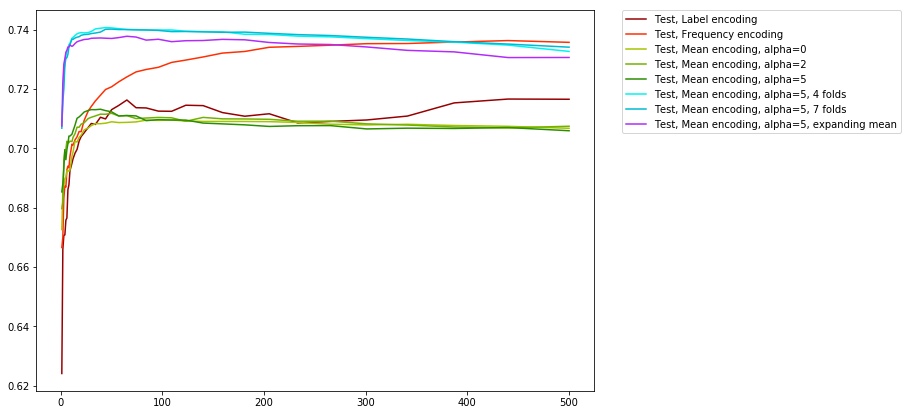

In [53]:
train_data, test_data = train_test_split(ctr, test_size=0.3, random_state=4)
testing_params = {'learning_rate':0.2}

test_all_encodings(train_data, test_data, target_col, testing_params, test_one_hot=False, regression=False)

__Takeaways__
1. Regularized mean encodings showed the best results on this data with very high cardinality features. That was expected, this case is actually a perfect case for mean encoding.
2. Frequency encoding showed a very good result, again, but again with a huge amount of trees needed to get to a good score.
3. Unregularized mean encodings all cause overfitting and lead to a bad score.

<h1>Summary and conclusions</h1>
<h2> Summary</h2>

In [54]:
agg_results = {'Encodings':['Samples', 'Cardinality', 'One-hot','Label','Frequency','Mean encoding, alpha=0',
                            'Mean encoding, alpha=2','Mean encoding, alpha=5',
                            'Mean encoding, alpha=5, 4 folds','Mean encoding, alpha=5, 7 folds',
                            'Mean encoding, alpha=5, expanding mean'],
              'IMDB movie revenue':['872', 'High/Average', 1, 6, 9, 5, 4, 7, 2, 3, 8],
              'Video Game Sales':['16291', 'High/average/low', 8, 3, 4, 7, 5, 6, 1, 2, 9],
              'World Bank poverty prediction':['37560', 'Average/low', 6, 5, 1, 3, 4, 2, 8, 7, 9],
              'World Bank poverty prediction with feature interactions':['37560', 'High/average/low', 
                                                                         6, 2, 1, 7, 8, 4, 3, 5, 9], 
              'Home Credit Default Risk':['109742', 'High/average', 'not tested', 7, 4, 8, 6, 5, 1, 2, 3],
              'Avazu Click-Through Rate Prediction':['100000', 'High', 'not tested', 5, 4, 8, 7, 6, 1, 2, 3],
              'Median position':[np.nan, np.nan, 6, 5, 4, 7, 5, 5, 1, 2, 8]}
agg_results = pd.DataFrame(agg_results)
agg_results = agg_results.loc[:,['Encodings', 'Median position', 'IMDB movie revenue', 'Video Game Sales',
                                 'World Bank poverty prediction', 
                                 'World Bank poverty prediction with feature interactions',
                                 'Home Credit Default Risk', 'Avazu Click-Through Rate Prediction']]
agg_results

,Encodings,Median position,IMDB movie revenue,Video Game Sales,World Bank poverty prediction,World Bank poverty prediction with feature interactions,Home Credit Default Risk,Avazu Click-Through Rate Prediction
0,Samples,NaN,872,16291,37560,37560,109742,100000
1,Cardinality,NaN,High/Average,High/average/low,Average/low,High/average/low,High/average,High
2,One-hot,6.0,1,8,6,6,not tested,not tested
3,Label,5.0,6,3,5,2,7,5
4,Frequency,4.0,9,4,1,1,4,4
5,"Mean encoding, alpha=0",7.0,5,7,3,7,8,8
6,"Mean encoding, alpha=2",5.0,4,5,4,8,6,7
7,"Mean encoding, alpha=5",5.0,7,6,2,4,5,6
8,"Mean encoding, alpha=5, 4 folds",1.0,2,1,8,3,1,1
9,"Mean encoding, alpha=5, 7 folds",2.0,3,2,7,5,2,2


<h2> Conclusions</h2><br>
For features with high cardinality:

1. I suggest to try mean encoding with 4 or 5 folds and  α=5  first, and then try a frequency encoding. Maybe using both encodings will benefit the model.
2. Then if the dataset is big enough (>50000 examples) and the score is still unsatisfactory, try expanding mean regularization.
3. Try one-hot encodings for high cardinality features only in case of very small datasets, or if you just really, really want to try it, your gut just screams that it will work best, then do it.
4. There is no point in using mean encoding with  α=0  and no regularization. At least use  α=5  and even that will be not as good as k-fold regularization on a bigger datasets, but can sometimes work better on smaller ones (<50000).
<br>

For features with low cardinality:

1. I suggest you to try label encoding and frequency encoding first.
2. If the results are unsatisfactory, try mean encoding with 4 or 5 folds and  α=5.
3. Then you can try to create some feature interactions and try different mean encodings for them.
<br>

For datasets with < 50000 rows:

1. Try label encoding and frequency encoding first. If the dataset is very small, try one-hot encoding, but remember, it will affect feature sampling process, so it is probably better to use all features for every tree/split, the data is small anyway, so the speed should not be a problem.
2. Do not use too much regularization with mean encodings, 4 or 5 folds and  α=5  is the first choice again, expanding mean, most likely, will not work here.